# Algorithmen aus dem Buch Kapitel 10 Data Mining

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = True  # Use per default a grid, i.e. plt.grid()
#from collections import namedtuple
from dataclasses import dataclass

## Klassifikation 

Bei dieser Art von Problemen geht es darum Daten möglichst gut zu klassifizieren.

Beispielsweise bei Früchten zu unterscheiden, ob diese eine Apfel oder eine Birne ist.

Nun wollen wir uns zunächst ein paar einfache Daten Mengen angucken und überlegen, ob wir bei diesen eine linearen Diskreminante finden.

### Generieren der Daten, die wir Klassifzieren wollen

In [3]:
@dataclass
class Dataset:
    name: str
    features: np.array 
    labels: np.array 

In [4]:
def generate_circles_dataset(number_of_samples=1000, random_state=np.random):
    labels = random_state.choice([0, 1], size=number_of_samples)
    features = random_state.normal(size=(number_of_samples, 2))
    features /= np.linalg.norm(features, axis=-1, keepdims=True)
    features *= labels[:, None] + 1 / 1.1 * random_state.uniform(size=number_of_samples)[:, None]
    return Dataset('circles', features, labels)

def generate_blobs_dataset(number_of_samples=1000, scale=1, random_state=np.random, name='blobs'):
    labels = random_state.choice([0, 1], size=number_of_samples)
    cluster_centers = random_state.normal(scale=scale, size=(2, 2))
    features = cluster_centers[labels, :] + random_state.normal(size=(number_of_samples, 2))
    return Dataset(name, features, labels)

In [5]:
blobs = generate_blobs_dataset(scale=2.2, random_state=np.random.RandomState(0), name='blobs')
circles = generate_circles_dataset(random_state=np.random.RandomState(0))
hard_blobs = generate_blobs_dataset(scale=1, random_state=np.random.RandomState(0), name='hard_blobs')

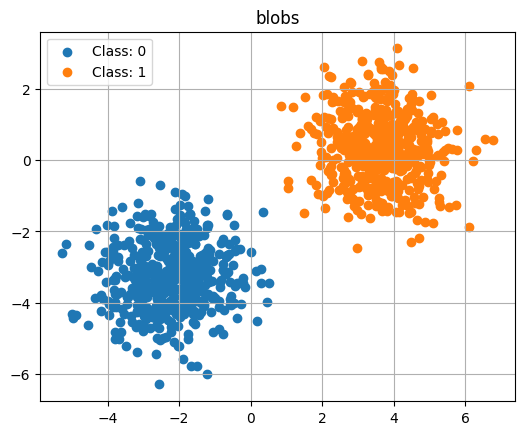

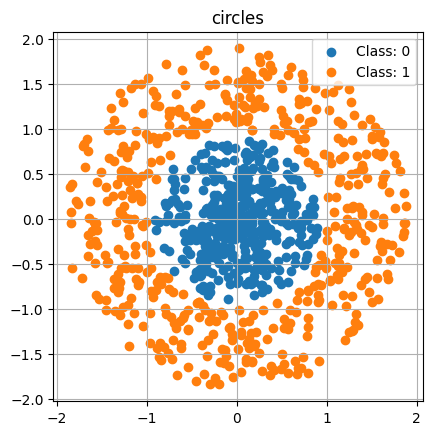

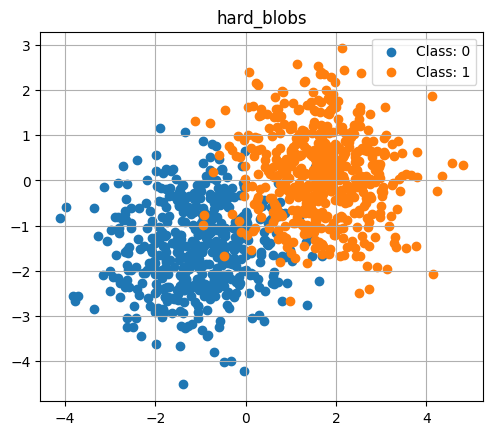

In [6]:
def plot_dataset(dataset, ax=None, title=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    classes = np.unique(dataset.labels)
    classes = np.sort(classes)
    for c in classes:
        ax.scatter(
            dataset.features[dataset.labels == c, 0],
            dataset.features[dataset.labels == c, 1],
            label=f'Class: {c}',
        )
    ax.set_aspect('equal')
    if title is None:
        title = dataset.name
    ax.set_title(title)
    ax.legend()


plot_dataset(blobs)
plot_dataset(circles)
plot_dataset(hard_blobs)


Nun müssen wir noch unsere beiden Datensets in Training und Test Sets aufteilen. Dies übernimmt der folgede Code:

In [7]:
def split_blobs(number_of_samples=200):
    return Dataset('train_blobs', blobs.features[0:number_of_samples], blobs.labels[0:number_of_samples]), Dataset('test_blobs', blobs.features[number_of_samples:], blobs.labels[number_of_samples:])

def split_circles(number_of_samples=200):
    return Dataset('train_circles', circles.features[0:number_of_samples], circles.labels[0:number_of_samples]), Dataset('test_circles', circles.features[number_of_samples:], circles.labels[number_of_samples:])

def split_hard_blobs(number_of_samples=200):
    return Dataset('train_hard_blobs', hard_blobs.features[0:number_of_samples], hard_blobs.labels[0:number_of_samples]), Dataset('test_hard_blobs', hard_blobs.features[number_of_samples:], hard_blobs.labels[number_of_samples:])

train_blobs, test_blobs = split_blobs()
train_circles, test_circles = split_circles()
train_hard_blobs, test_hard_blobs = split_hard_blobs()

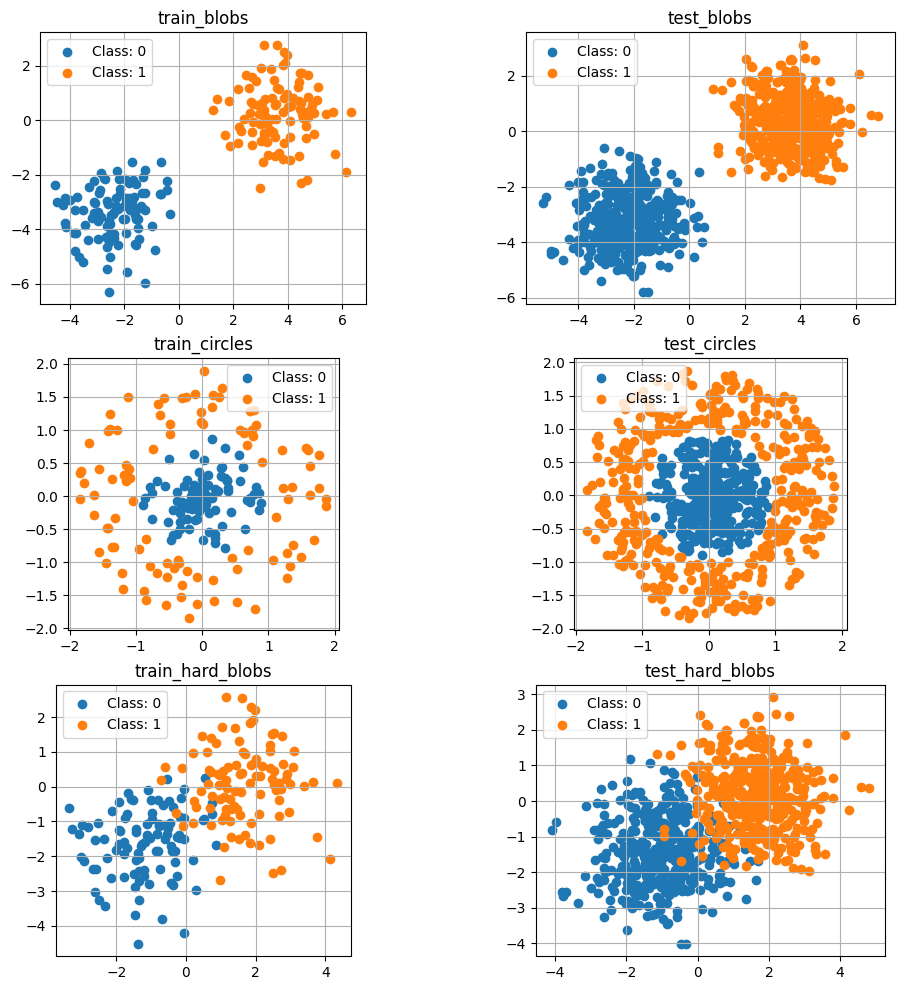

In [8]:
figure, axes = plt.subplots(3, 2, figsize=(12, 12))
plot_dataset(train_blobs, ax=axes[0, 0])
plot_dataset(test_blobs, ax=axes[0, 1])
plot_dataset(train_circles, ax=axes[1, 0])
plot_dataset(test_circles, ax=axes[1, 1])
plot_dataset(train_hard_blobs, ax=axes[2, 0])
plot_dataset(test_hard_blobs, ax=axes[2, 1])

### K-NN

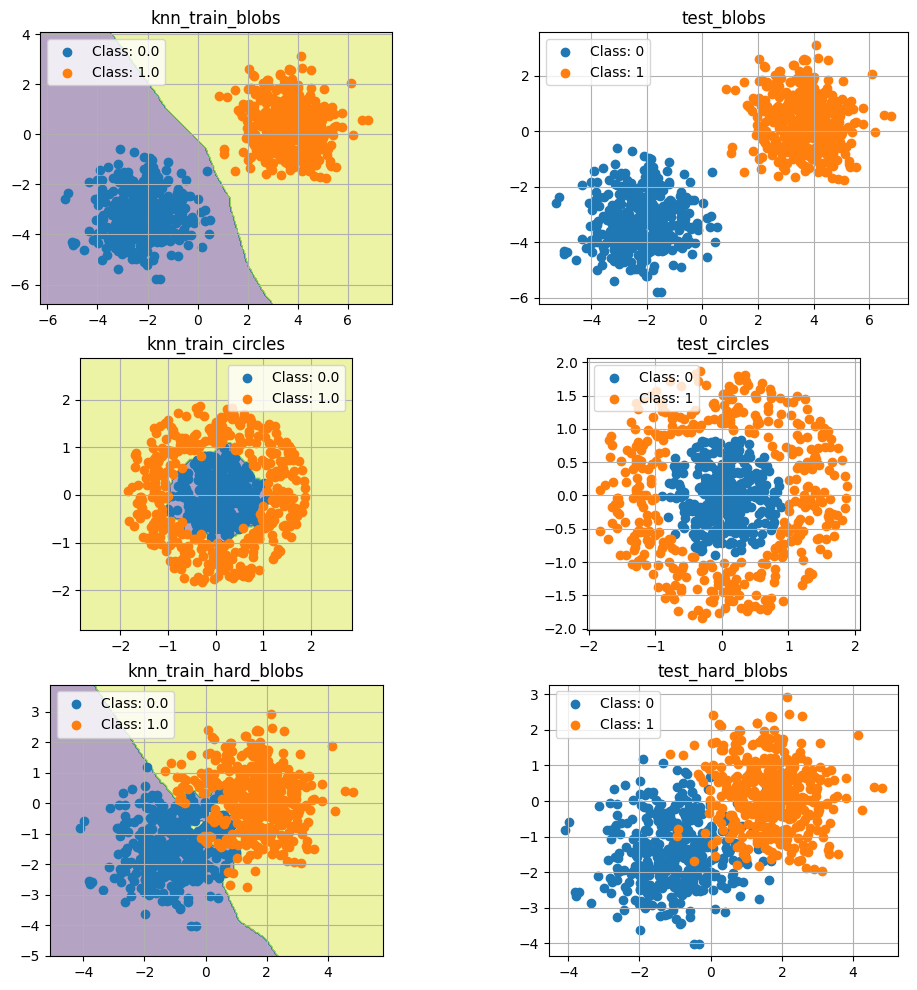

In [34]:
def knn(training : Dataset, test : np.array , k=1, name_override=None):
    distances = np.sum((test[:, None] - training.features[None]) ** 2, axis=-1)
    nearest = np.argsort(distances, axis=-1)[:, :k]
    return Dataset(
        f'knn_{name_override or training.name}',
        test,
        np.mean(training.labels[nearest], axis=-1)
    )

def knn_decision_boundary(train : Dataset, test : Dataset, k=1):
    x_min, x_max = test.features[:, 0].min() - 1, test.features[:, 0].max() + 1
    y_min, y_max = test.features[:, 1].min() - 1, test.features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    Z = knn(train, np.c_[xx.ravel(), yy.ravel()], k=k).labels
    Z = Z.reshape(xx.shape)
    return xx, yy, Z

def plot_decision_boundary(decision_boundary, ax):
    xx, yy, Z = decision_boundary
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return figure, axes

knn_circles = knn(train_circles, test_circles.features, k=1)
knn_blobs = knn(train_blobs, test_blobs.features, k=1)
knn_hard_blobs = knn(train_hard_blobs, test_hard_blobs.features, k=1)
knn_circles_decision_boundary = knn_decision_boundary(train_circles, test_circles, k=1)
knn_blobs_decision_boundary = knn_decision_boundary(train_blobs, test_blobs, k=1)
knn_hard_blobs_decision_boundary = knn_decision_boundary(train_hard_blobs, test_hard_blobs, k=1)
figure, axes = plt.subplots(3, 2, figsize=(12, 12))
plot_decision_boundary(knn_blobs_decision_boundary, axes[0, 0])
plot_decision_boundary(knn_circles_decision_boundary, axes[1, 0])
plot_decision_boundary(knn_hard_blobs_decision_boundary, axes[2, 0])
plot_dataset(knn_blobs, ax=axes[0, 0])
plot_dataset(test_blobs, ax=axes[0, 1])
plot_dataset(knn_circles, ax=axes[1, 0])
plot_dataset(test_circles, ax=axes[1, 1])
plot_dataset(knn_hard_blobs, ax=axes[2, 0])
plot_dataset(test_hard_blobs, ax=axes[2, 1])

### LDA

Wie bereits in meinem Vortrag erklärt, handelt es sich hierbei um einen Spezialfall: Wir nehmen an, dass die Diskreminante linear ist.

Welche unserer Sample Muster sind dann übehaupt noch sinnvoll?

Hier noch einmal die loglikelihood function, welche wir optimieren wollen:
\begin{align}
\ell( w_0, \mathbf w) &= \sum_{n=1}^N \bigg(
\tilde c_n \ln \, \sigma(\mathbf w^{\mathsf T}\mathbf x_n + w_0) + (1-\tilde c_n)\ln\,\big(1-\sigma(\mathbf w^{\mathsf T}\mathbf x_n + w_0)\big)
\bigg) \\
\tilde c_n &\in \{0, 1\}
\end{align}

Da wir diese loss function mit gradient Methoden optimieren wollen, müssen wir zu nächst die Ableitugen der einzelnen Bestandteile berechnen.
\begin{align}
\frac{\partial \sigma(x)}{\partial x}
&= -\frac{1}{(1+\mathrm e^{-x})^2} \cdot \mathrm e^{-x} \cdot (-1) \\  % REPLACE &= \color{red}{???}
&= \frac{\mathrm e^{-x}}{(1+\mathrm e^{-x})^2} \\  % REPLACE
&= \color{red}{\frac{1}{1+\mathrm e^{-x}}} \cdot \color{green}{\frac{\mathrm e^{-x}}{1+\mathrm e^{-x}}} \\  % REPLACE
&= \color{red}{\sigma(x)} \cdot \color{green}{(1-\sigma(x))}  % REPLACE
\end{align}

Folglich ist die Abeleitung der Kostenfunktion selber: 

\begin{align}
\frac{\partial\ell}{\partial w_0}
&= \sum_{n=1}^N \bigg(  % REPLACE &= \color{red}{???}
\tilde c_n \cdot \frac{1}{\sigma(\dots)} \cdot \sigma(\dots) \cdot \big(1-\sigma(\dots)\big)  % REPLACE
+ (1 - \tilde c_n) \cdot \frac{1}{1-\sigma(\dots)} \cdot (-1) \sigma(\dots) \cdot \big(1-\sigma(\dots)\big)  % REPLACE
\bigg) \\  % REPLACE
&= \sum_{n=1}^N \bigg(  % REPLACE
\tilde c_n \big(1-\sigma(\dots)\big)  % REPLACE
- (1 - \tilde c_n) \sigma(\dots)  % REPLACE
\bigg) \\  % REPLACE
&= \sum_{n=1}^N \bigg(  % REPLACE
\tilde c_n - \sigma(\mathbf w^{\mathsf T} \mathbf x_n + w_0)  % REPLACE
\bigg)  % REPLACE
\end{align}

\begin{align}
\frac{\partial\ell}{\partial w_d}
&= \sum_{n=1}^N \bigg(  % REPLACE &= \color{red}{???}
\tilde c_n \cdot \frac{1}{\sigma(\dots)} \cdot \sigma(\dots) \cdot \big(1-\sigma(\dots)\big) x_{d,n}  % REPLACE
+ (1 - \tilde c_n) \cdot \frac{1}{1-\sigma(\dots)} \cdot (-1) \sigma(\dots) \cdot \big(1-\sigma(\dots)\big) x_{d,n}  % REPLACE
\bigg) \\  % REPLACE
&= \sum_{n=1}^N x_{d,n} \bigg(  % REPLACE
\tilde c_n \big(1-\sigma(\dots)\big)  % REPLACE
- (1 - \tilde c_n) \sigma(\dots)  % REPLACE
\bigg) \\  % REPLACE
&= \sum_{n=1}^N x_{d,n} \bigg(  % REPLACE
\tilde c_n - \sigma(\mathbf w^{\mathsf T} \mathbf x_n + w_0)  % REPLACE
\bigg)  % REPLACE
\end{align}


\begin{align}
\mathbf w^{(\kappa + 1)}
&= \mathbf w^{(\kappa)} + \mu \left.\frac{\partial\ell}{\partial \mathbf w}\right|_{w_0^{(\kappa)}, \mathbf w^{(\kappa)}} &  % REPLACE &= \color{red}{???} &
w_0^{(\kappa + 1)}
&= w_0^{(\kappa)} + \mu \left.\frac{\partial\ell}{\partial \mathbf w}\right|_{w_0^{(\kappa)}, \mathbf w^{(\kappa)}}  % REPLACE &= \color{red}{???}
\end{align}

## Gradient Decent

Im folgenden sind 3 Gradient Decent verfahren implimentiert.

### Batch Gradient Decent

In [61]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gradient_decent(w, w0, test: Dataset, learning_rate=0.1, epochs=1000, return_history=False):
    if return_history:
        history_w = [w]
        history_w0 = [w0]
    for i in range(epochs):
        grad_w0 = np.sum(test.labels - sigmoid(test.features@w + w0), axis=0)  
        grad_w = np.sum(((test.labels - sigmoid(test.features@w + w0)))[:, None] * test.features, axis=0)
        w0 += learning_rate * grad_w0
        w += learning_rate * grad_w
        if return_history:
            history_w.append(w.copy())
            history_w0.append(w0)
    if return_history:
        return history_w, history_w0
    return w, w0

Die hierdurch erreichte Entscheidungsregel: 

[4.89482776 2.52747658] 0.342592481645587


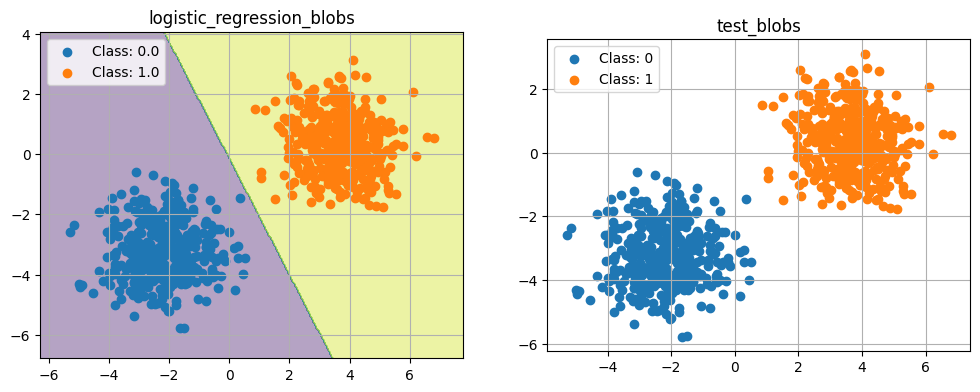

In [62]:
# train on train_blobs dataset and test on test_blobs dataset
w, w0 = gradient_decent(np.array([1.0, 1.0]), 0.0, train_blobs, learning_rate=0.1, epochs=1000)
print(w, w0)
# test on test_blobs dataset
predictions = sigmoid(np.dot(w, test_blobs.features.T) + w0)
predictions = np.round(predictions)
# plot results including desicion boundary
figure, axes = plt.subplots(1, 2, figsize=(12, 6))
x_min, x_max = test_blobs.features[:, 0].min() - 1, test_blobs.features[:, 0].max() + 1
y_min, y_max = test_blobs.features[:, 1].min() - 1, test_blobs.features[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))
Z = sigmoid(np.dot(w, np.c_[xx.ravel(), yy.ravel()].T) + w0)
Z = np.round(Z)
Z = Z.reshape(xx.shape)
axes[0].contourf(xx, yy, Z, alpha=0.4)
axes[0].set_xlim(xx.min(), xx.max())
axes[0].set_ylim(yy.min(), yy.max())
plot_dataset(test_blobs, ax=axes[1])
plot_dataset(Dataset('logistic_regression_blobs', test_blobs.features, predictions), ax=axes[0])


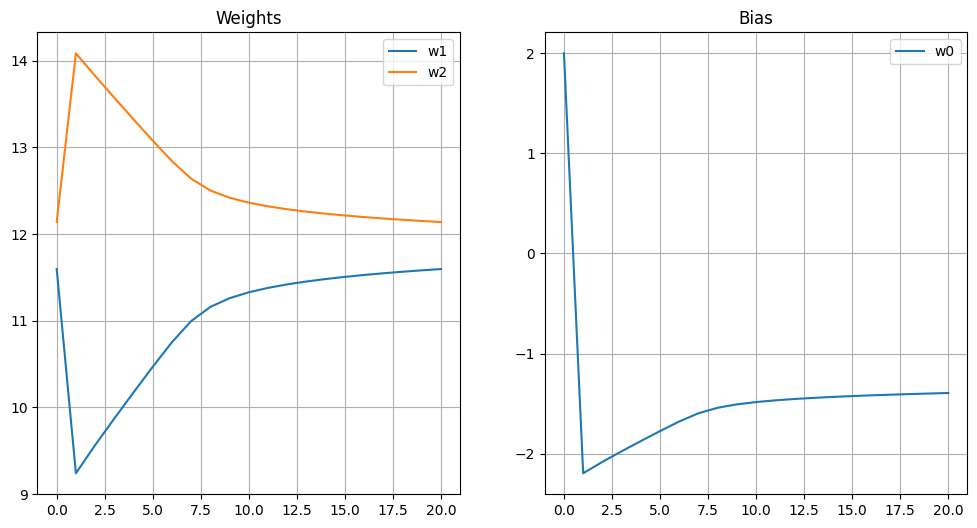

In [65]:
#Plot the history of the weights
figure, axes = plt.subplots(1, 2, figsize=(12, 6))
history_w, history_w0 = gradient_decent(np.array([1.0, 0.0]), 2.0, train_blobs, learning_rate=0.1, epochs=20, return_history=True)
history_w = np.array(history_w)
history_w0 = np.array(history_w0)
axes[0].plot(history_w[:, 0], label='w1')
axes[0].plot(history_w[:, 1], label='w2')
axes[0].legend()
axes[0].set_title('Weights')
axes[1].plot(history_w0, label='w0')
axes[1].set_title('Bias')
axes[1].legend()

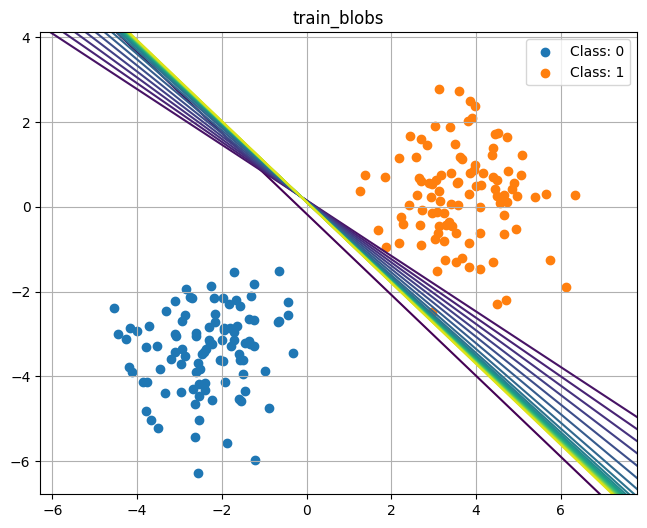

In [66]:
# using a color map from matplotlib, display the lines corresponding to w1*x1 + w2*x2 + w0 = 0, i.e. x2 = -w1/w2 * x1 - w0/w2
figure, ax = plt.subplots(1, 1, figsize=(12, 6))

x_min, x_max = test_blobs.features[:, 0].min() - 1, test_blobs.features[:, 0].max() + 1
y_min, y_max = test_blobs.features[:, 1].min() - 1, test_blobs.features[:, 1].max() + 1

for i, (w, w0) in enumerate(zip(history_w, history_w0)):
    x = np.linspace(x_min, x_max, 2)
    y = -w[0]/w[1] * x - w0/w[1]
    ax.plot(x, y, color=plt.cm.viridis(i/len(history_w)))

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# plot blobs, too
plot_dataset(train_blobs, ax=ax)

In [15]:
def compute_complete_grid(xlim, ylim, steps):
    x, y = np.meshgrid(np.linspace(*xlim, steps),np.linspace(*ylim, steps))
    return x, y, np.stack([x, y], axis=-1)

def fit_and_plot(dataset, levels=[0], **kwargs):
    """
    ??? Add a doc string. What does this function do? What are the input parameters? Which shape?
    """
    w_tilde, loss_history = fit_function(dataset,transform_fn=transform_fn,**kwargs,)
    
    _, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot loss history
    axes[0].plot(loss_history)
    axes[0].set_title('{}, final loss: {}'.format(dataset.name, loss_history[-1]))
    # Use log scale above 1e-5 and linear scale below
    axes[0].set_yscale("symlog", linthresh=1e-5)
    
    
    # Plot decision boundary if in area
    steps = 100
    x, y, features_grid = compute_complete_grid(
        (np.min(dataset.features[:, 0]), np.max(dataset.features[:, 0])),
        (np.min(dataset.features[:, 1]), np.max(dataset.features[:, 1])),
        steps=steps
    )
    features_grid = features_grid.reshape(steps * steps, 2)
    features_grid = add_augmentation(features_grid)
    z, _ = predict_rosenblatt_perceptron(features_grid, w_tilde, transform_fn=transform_fn)
    z = np.reshape(z, (steps, steps))
    
    if np.any(z < 0) and np.any(z > 0):
        axes[1].contourf(x, y, z >= 0, colors=['cyan', 'yellow'], alpha=0.2)
        plot_dataset(dataset, ax=axes[1])
        axes[1].contour(x, y, z, levels=levels)
    else:
        axes[1].contourf(x, y, z >= 0, colors=['cyan', 'yellow'],  alpha=0.2)
        plot_dataset(dataset, ax=axes[1])
        axes[1].contour(x, y, z)
    plt.show()
    
    print('w_tilde', w_tilde)

NameError: name 'fit_rosenblatt_perceptron' is not defined

### Stochastic Gradient Decent

### Mini Batch Stochastic Gradient Decent 

In [ ]:
def get_learning_rate(epoch):
    # This is a fixed learning rate schedule.
    initial_learning_rate = 0.01  # REPLACE ???
    if epoch <= 5:  # REPLACE return ???
        return initial_learning_rate  # REPLACE
    else:  # REPLACE
        return initial_learning_rate * 10 ** -(epoch - 5)  # REPLACE

def get_gradient_theta(X, y, theta):
    batch_size = X.shape[0]  # REPLACE
    return -(X.T @ y - X.T @ X @ theta) / batch_size  # REPLACE return ???

def fit(
    X_train, y_train,
    X_test, y_test,
    epochs=10,
    batch_size=10,
    logging=True
):
    number_of_examples, number_of_parameters = X_train.shape
    
    # Set up batching parameters
    all_example_indices = list(range(number_of_examples))
    number_of_batches = -(-number_of_examples // batch_size)
    
    # Initialize variables
    theta = np.zeros(number_of_parameters)
    
    # Prepare logging
    if logging:
        train_error_history = []
        test_error_history = []
        theta_history = []
    else:
        train_error_history = None
        test_error_history = None
        theta_history = None
    
    for epoch in range(epochs):
        learning_rate = get_learning_rate(epoch)
        np.random.shuffle(all_example_indices)  # REPLACE ???  # shuffle all_example_indices
        
        for mini_batch in np.array_split(all_example_indices, number_of_batches):  # REPLACE ???  # for mini_batch in ???:
            gradient = get_gradient_theta(  # REPLACE ???
                X_train[mini_batch, :],  # REPLACE
                y_train[mini_batch],  # REPLACE
                theta  # REPLACE
            )  # REPLACE
            theta = theta - learning_rate * gradient  # REPLACE
            
            if logging:
                theta_history.append(theta)
                train_error_history.append(
                    root_mean_squared_error(X_train, y_train, theta)
                )
                test_error_history.append(
                    root_mean_squared_error(X_test, y_test, theta)
                )
    
    if logging:
        train_error_history = np.asarray(train_error_history)
        test_error_history = np.asarray(test_error_history)
        theta_history = np.asarray(theta_history)
    
    return theta, train_error_history, test_error_history, theta_history

theta, train_error_history, test_error_history, theta_history = fit(
    X, y,
    X_test, y_test,
    epochs=10,
    batch_size=10,
    logging=True
)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

ax = axes[0]
ax.plot(np.log(train_error_history), label='Train error')
ax.plot(np.log(test_error_history), color='red', label='Test error')
ax.set_xlabel('Iteration')
ax.set_ylabel('Root Mean Squared Error')
ax.legend()

ax = axes[1]
ax.plot(theta_history[:, 0], theta_history[:, 1])
ax.scatter(theta[0], theta[1], color='red', zorder=3, s=100)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')

plt.show()
print('Best test loss: {:10.0f}'.format(np.min(test_error_history)))

## K - Means Clustering 

Ein Algo. der im Kontext von unsupervised learning verwendet wird

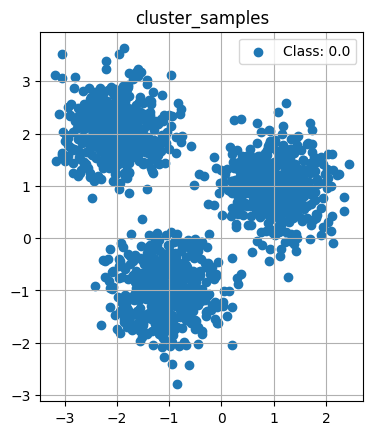

In [12]:
def cluster_samples(N = 1500, K = 3,means = np.array([[-1, -1], [1, 1], [-2, 2]])):
    x = np.sqrt(1 / 4) * np.random.normal(size=(N, 2))
    for n in range(N):
        k = np.random.choice(K)
        x[n, :] += means[k, :]
    return Dataset('cluster_samples', x, np.zeros(N))

test_cluster_samples = cluster_samples()
plot_dataset(test_cluster_samples)

Implementation des K-Means Clustering

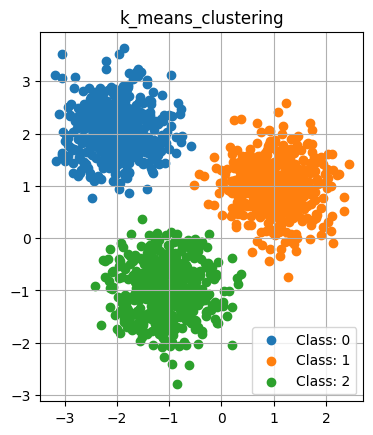

In [14]:
def k_means_clustering(test : Dataset, K = 3, max_iter = 100):
    N, D = test.features.shape
    means = test.features[np.random.choice(N, K, replace=False)]
    for _ in range(max_iter):
        distances = np.sum((test.features[:, None] - means[None]) ** 2, axis=-1)
        labels = np.argmin(distances, axis=-1)
        for k in range(K):
            means[k] = np.mean(test.features[labels == k], axis=0)
    return Dataset('k_means_clustering', test.features, labels)
plot_dataset(k_means_clustering(test_cluster_samples))